# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor, plot_importance
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

### Первый взгляд на данные

In [38]:
data = pd.read_csv(r'D:\\PC\Downloads\autos.csv')
#data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [39]:
data.sample(n=5)

In [40]:
data.info()

### Предобработка данных

#### Ненужные столбцы

В датасете присутствуют ненужные для нас столбцы, удалим их.

In [41]:
data = data.drop(columns=['DateCrawled', 'NumberOfPictures', 'LastSeen', 'DateCreated'])

#### Дубликаты

In [42]:
# Проверка на дубликаты
print('Кол-во дубликатов:', data.duplicated().sum())
print(f'Доля дубликатов:   {round((data.duplicated().sum() / data.shape[0] * 100), 1)}%')

В датасете представлены дубликаты данных, удалим их.

In [43]:
data.drop_duplicates(inplace=True)
print('Кол-во дубликатов:', data.duplicated().sum())

**Примечание**

При полном наборе столбцов в датасете, дубликатов всего 4 штуки. Найденные "дубликаты" скорее всего явлюятся разными объявлениями о разных машинах с одинаковыми характеристиками. Так же, возможно, некоторые объявления об одних и тех же машинах выкладывались несколько раз. Я решил их удалить, поскольку для модели они все равно по-сути являются одинаковыми. 

#### Выбросы

In [44]:
data.describe()

При исследовании описательных статистик можно заметить выбросы:

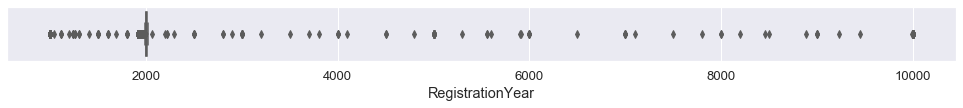

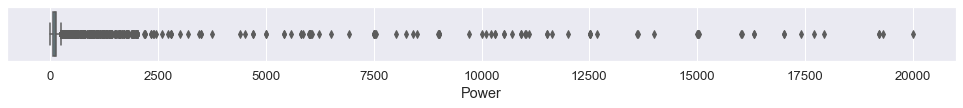

In [45]:
sns.set(style='darkgrid', palette='deep', font_scale=1.2)

for column in ['RegistrationYear', 'Power']:
    plt.figure(figsize=(17, 1))
    sns.boxplot(data[column], color='c')
    plt.show()

Огромное количество выбросов по мощности и году регистрации, их придется удалить. Используем

In [46]:
# Функция удаляет выбросы исходя из 1.5 интерквартильного размаха

def remove_outlier(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    fence_low = q1 - 3 * iqr
    fence_high = q3 + 3 * iqr
    new_data = data.loc[(data[column] > fence_low) &
                         (data[column] < fence_high)]
    return new_data

In [47]:
data = remove_outlier(data, 'RegistrationYear')
data = remove_outlier(data, 'Power')

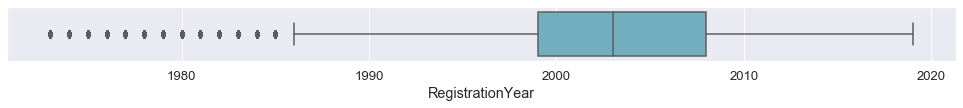

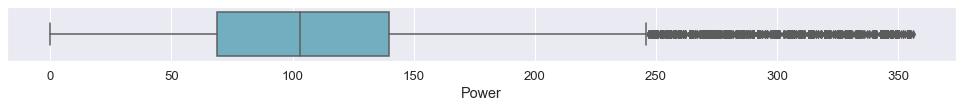

In [48]:
for column in ['RegistrationYear', 'Power']:
    plt.figure(figsize=(17, 1))
    sns.boxplot(data[column], color='c')
    plt.show()

#### Пропуски

In [49]:
# Выведем долю пропусков по столбцам
nan_data = data.isna().sum() / data.shape[0] * 100
nan_data[nan_data > 0]

В столбце с информацией о ремонте пропуски скорее всего означают отрицательный ответ, сделаем замену на "no".

В остальных столбцах пропуски придется удалить - замена их на other только снижает качество модели.

In [50]:
# Заполним пропуски и сделаем проверку
data['NotRepaired'].fillna('no', inplace=True)
data.dropna(inplace=True)
#data.fillna('other', inplace=True)

print('Кол-во пропусков:', data.isna().sum().sum())
data.shape

#### Почтовый индекс

Попробуем использовать регион продажи в качестве категориального признака

In [51]:
# Функция переводит индекс в строки и возвращает первые две цифры (регион)
def postal_code(row):
    row = str(row)
    if len(row) < 5:
        return int(row[:1])
    else: return int(row[:2])

In [52]:
data['PostalCode'] = data['PostalCode'].apply(postal_code)

In [53]:
data.describe()

In [54]:
data.info()

### Кодирование признаков и разделение выборок

In [55]:
encoder = OrdinalEncoder()
cats = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
data[cats] = encoder.fit_transform(data[cats])
#data[cats] = data[cats].astype('category')
data.head(3)

In [56]:
# Выделим выборки
features = data.drop(columns='Price')
target = data['Price']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=12345)

for sample in [X_train, X_test, y_train, y_test]:
    print(sample.shape)

### Масштабирование

In [57]:
#scaler = StandardScaler()
#numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
#numeric = X_train.columns
#scaler.fit(X_train[numeric])
#X_train[numeric] = scaler.transform(X_train[numeric])
#X_test[numeric] = scaler.transform(X_test[numeric])

## Обучение моделей

In [58]:
rmse = lambda true, preds: mean_squared_error(true, preds) ** 0.5

In [59]:
def draw_preds(preds, y=y_test):
    plt.figure(figsize=(10, 5))
    sns.distplot(y)
    sns.distplot(preds)
    plt.legend(['Ответы', 'Предсказания'])
    plt.xlabel('Цена')
    plt.title('Графики правильных ответов и предсказаний')
    plt.show()

In [60]:
def grid_train(model, params):
    grid = GridSearchCV(model, params, n_jobs=-1, cv=2)
    grid.fit(X_train, y_train)
    preds = grid.predict(X_test)
    print('Параметры лучшей модели', grid.best_params_)
    return grid.best_estimator_

In [61]:
def test_model(model, y_test=y_test):
    preds = model.predict(X_test)
    print('RMSE лучшей модели', round(rmse(y_test, preds), 2))
    draw_preds(preds)

In [62]:
%%time
# Линейная регрессия
regression = grid_train(LinearRegression(), params={})

In [63]:
%%time
# LightGBM
# Лучшие параметры были найдены подбором через gridsearch, 
# зафиксировал их здесь сразу, чтобы не тратить время
params = dict(n_estimators=[1000],
             learning_rate=[0.1],
             max_depth=[30],
             num_leaves=[50])

lgbm = grid_train(LGBMRegressor(random_state=12345), params)

## Анализ моделей

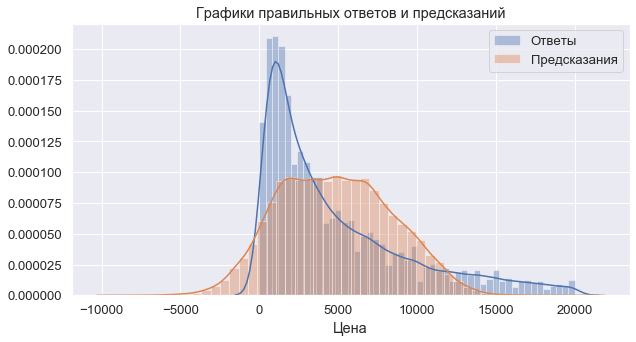

In [64]:
%%time
test_model(regression)

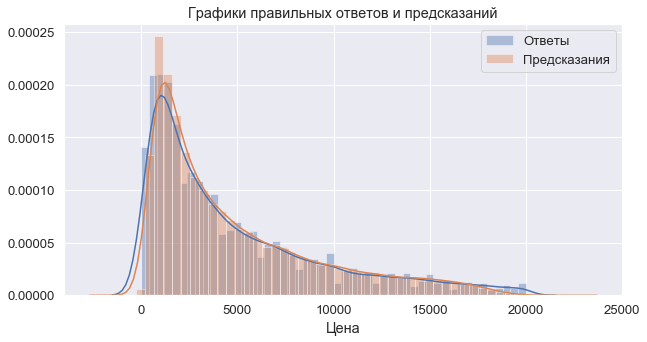

In [65]:
%%time
test_model(lgbm)

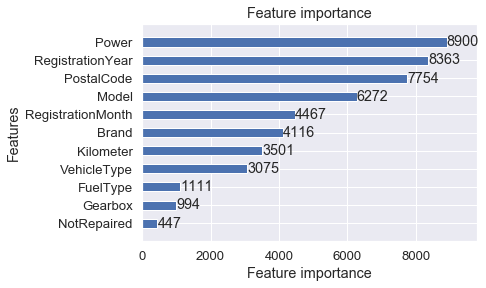

In [77]:
# Проверим важность признаков
plot_importance(lgbm, height=0.5)

## Вывод

В результате анализа работы различных моделей лучшей оказалась модель LightGBM с RMSE 1600, временем обучения и предсказаний 44 и 3 секунды соответственно. Самыми важными признаками для модели оказались мощность, год регистрации и регион(почтовый индекс) продавца.

Так же были проанализированы модели линейной регрессии, случайного леса и регрессора CatBoost. Первая модель показала себя очень плохо в плане качества, остальные две обучались слишком долго и показали качество немного хуже LightGBM.